<h1 align="center"> Image Captioning (10 баллов) </h1>

В этом ноутбуке вы обучите сеть составлять подписи к изображениям.
![img](https://i.imgur.com/obITaMl.png)


#### План работы:

1. Использовать предобученную модель Inception v3 для преобразования изображений в векторы.

2. Добавить поверх неё LSTM.

3. Обучить модель на датасете [MSCOCO](http://cocodataset.org/#download).

### 1. Данные (0.5 балла)

In [ ]:
!gdown --id 1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO
From (redirected): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO&confirm=t&uuid=bfc47967-b191-4799-bd58-f1e3f2259612
To: /content/handout.tar.gz
100% 884M/884M [00:18<00:00, 48.5MB/s]


In [ ]:
import tarfile

with tarfile.open('handout.tar.gz', 'r') as tar_ref:
    tar_ref.extractall('.')

/tmp/ipython-input-3766694136.py:4: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall('.')


In [ ]:
!rm -rf handout.tar.gz

In [ ]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 108 ms, sys: 378 ms, total: 486 ms
Wall time: 487 ms



Чтобы сэкономить ваше время, мы уже преобразовали все изображения из MSCOCO17 в векторы с помощью предобученной сети Inception_v3 из библиотеки [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

Весь процесс занимает от одного дня на CPU до примерно 10 минут на трёх GPU Tesla M40. [Если хотите попробовать сделать это самостоятельно — пожалуйста.](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).


In [ ]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как видно, все подписи уже токенизированы и приведены к нижнему регистру. Теперь нам нужно разделить их и добавить специальные токены, обозначающие начало и конец подписи.

In [ ]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


Мы не хотим, чтобы сеть на каждом шаге предсказывала вероятности для миллиона слов, поэтому нужно немного сократить словарь.

Для этого посчитайте, **сколько раз встречается каждое слово** — так мы сможем решить, какие слова оставить в словаре.

In [ ]:
from collections import Counter
word_counts = Counter()

for caption in captions:
    for sent in caption:
        word_counts.update(sent)

In [ ]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [ ]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i, seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### 2. Построение нейронной сети (1.5 балла)

Как уже упоминалось, мы создадим RNN-модель для генерации текста, которая будет зависеть от векторов, полученных из CNN-части сети.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

Во время обучения мы будем использовать уже готовые вектора-признаков, а сеть Inception добавим на этапе инференса.


In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)


        self.emb = nn.Embedding(len(vocab), emb_size, pad_ix)

        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)

        self.logits = nn.Linear(lstm_units, len(vocab))

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)

        captions_emb = self.emb(captions_ix)  # [B, S, D]
        lstm_out, _ = self.lstm(captions_emb, (initial_cell.unsqueeze(0), initial_hid.unsqueeze(0)))  # [B, S, D]

        logits = self.logits(lstm_out)  # [B, S, D']

        return logits

In [ ]:
network = CaptionNet(n_tokens)
network.to(device)

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (emb): Embedding(10403, 128, padding_idx=3)
  (lstm): LSTM(128, 256, batch_first=True)
  (logits): Linear(in_features=256, out_features=10403, bias=True)
)

In [ ]:
dummy_img_vec = torch.randn(len(captions[0]), 2048, device=device)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64, device=device)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [ ]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """

    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    logits_for_next = network.forward(image_vectors, captions_ix_inp)

    loss = nn.CrossEntropyLoss(ignore_index=pad_ix)(
        logits_for_next.view(-1, logits_for_next.shape[-1]),
        captions_ix_next.view(-1)
    )
    return loss.unsqueeze(0)

In [ ]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.cpu().numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'


Добавьте ~~adam~~ ваш любимы оптимизатор для обучения.

In [ ]:
optimizer = torch.optim.Adam(network.parameters(), lr=3e-4)

### 3. Обучение (5 баллов)

* Сначала реализуйте генератор батчей.
* Затем обучите сеть как обычно.

In [ ]:
from sklearn.model_selection import train_test_split
# captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(
    img_codes,
    captions,
    test_size=0.1,
    random_state=42
)



In [ ]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    batch_images = img_codes[random_image_ix]

    batch_captions = []
    for img_idx in random_image_ix:
        img_captions = captions[img_idx]
        chosen_caption = choice(img_captions)
        batch_captions.append(chosen_caption)

    batch_captions_ix = as_matrix(batch_captions, max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32, device=device), torch.tensor(batch_captions_ix, dtype=torch.int64, device=device)

In [ ]:
generate_batch(img_codes,captions,3)

(tensor([[0.0996, 0.1445, 0.2341,  ..., 0.7410, 0.4430, 0.0058],
         [0.3799, 0.0754, 0.7549,  ..., 0.5701, 0.5677, 0.5739],
         [0.3937, 0.0543, 0.1648,  ..., 0.2719, 0.7175, 0.1641]],
        device='cuda:0'),
 tensor([[   1,   24,  195,  325,   50,   24,  895,   15,   50,   24,  139,   12,
             2],
         [   1,   24,   29,   63,   41,  651,  239,  185,  330,   24,   71,   12,
             2],
         [   1,   24, 6515,  121,   58, 2497,  185,  272,  130,   12,    2,    3,
             3]], device='cuda:0'))

In [ ]:
batch_size = 64
n_epochs = 25
n_batches_per_epoch = 512
n_validation_batches = 64

In [ ]:
from tqdm import tqdm

for epoch in range(n_epochs):

    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):

        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))

        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch

    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 512/512 [00:06<00:00, 80.83it/s]



Epoch: 0, train loss: 4.843486270401627, val loss: 4.170220997184515


100%|██████████| 512/512 [00:06<00:00, 81.71it/s]



Epoch: 1, train loss: 3.951469744555652, val loss: 3.756792612373829


100%|██████████| 512/512 [00:06<00:00, 80.25it/s]



Epoch: 2, train loss: 3.5900196279399097, val loss: 3.4465971626341343


100%|██████████| 512/512 [00:06<00:00, 80.17it/s]



Epoch: 3, train loss: 3.3729326422326267, val loss: 3.332616448402405


100%|██████████| 512/512 [00:06<00:00, 80.20it/s]



Epoch: 4, train loss: 3.219827943481505, val loss: 3.134814638644457


100%|██████████| 512/512 [00:06<00:00, 78.49it/s]



Epoch: 5, train loss: 3.1125137857161462, val loss: 3.1028290577232838


100%|██████████| 512/512 [00:06<00:00, 78.65it/s]



Epoch: 6, train loss: 3.0192104894667864, val loss: 3.016923788934946


100%|██████████| 512/512 [00:06<00:00, 79.11it/s]



Epoch: 7, train loss: 2.9497322496026754, val loss: 2.946089915931225


100%|██████████| 512/512 [00:06<00:00, 78.39it/s]



Epoch: 8, train loss: 2.9182915813289583, val loss: 2.898379698395729


100%|██████████| 512/512 [00:06<00:00, 78.87it/s]



Epoch: 9, train loss: 2.853806860744953, val loss: 2.8718656674027443


100%|██████████| 512/512 [00:06<00:00, 80.70it/s]



Epoch: 10, train loss: 2.7959633506834507, val loss: 2.8245227113366127


100%|██████████| 512/512 [00:06<00:00, 78.77it/s]



Epoch: 11, train loss: 2.776455098297447, val loss: 2.779229335486889


100%|██████████| 512/512 [00:06<00:00, 78.78it/s]



Epoch: 12, train loss: 2.7546120304614305, val loss: 2.7588271237909794


100%|██████████| 512/512 [00:06<00:00, 78.97it/s]



Epoch: 13, train loss: 2.7182671590708196, val loss: 2.7377315312623978


100%|██████████| 512/512 [00:06<00:00, 79.80it/s]



Epoch: 14, train loss: 2.7002201406285167, val loss: 2.6927341520786285


100%|██████████| 512/512 [00:06<00:00, 77.61it/s]



Epoch: 15, train loss: 2.6773656816221774, val loss: 2.6805602870881557


100%|██████████| 512/512 [00:06<00:00, 80.28it/s]



Epoch: 16, train loss: 2.6623131670057774, val loss: 2.6891925297677517


100%|██████████| 512/512 [00:06<00:00, 77.44it/s]



Epoch: 17, train loss: 2.6387242935597897, val loss: 2.6690441705286503


100%|██████████| 512/512 [00:06<00:00, 79.62it/s]



Epoch: 18, train loss: 2.6226070318371058, val loss: 2.654310043901205


100%|██████████| 512/512 [00:06<00:00, 79.02it/s]



Epoch: 19, train loss: 2.60077288094908, val loss: 2.6423726305365562


100%|██████████| 512/512 [00:06<00:00, 80.64it/s]



Epoch: 20, train loss: 2.57939536543563, val loss: 2.626361794769764


100%|██████████| 512/512 [00:06<00:00, 79.30it/s]



Epoch: 21, train loss: 2.5752233774401248, val loss: 2.6291826888918877


100%|██████████| 512/512 [00:06<00:00, 79.60it/s]



Epoch: 22, train loss: 2.5585285457782447, val loss: 2.604735504835844


100%|██████████| 512/512 [00:06<00:00, 79.80it/s]



Epoch: 23, train loss: 2.5400900868698955, val loss: 2.58015875890851


100%|██████████| 512/512 [00:06<00:00, 80.05it/s]



Epoch: 24, train loss: 2.546506784390658, val loss: 2.598671078681946
Finished!


### 4. Применяем обученную модель (0.5 балла)

Теперь загрузим предобученнную Inceprion модель и посмотрим, на что способна наша модель.


In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torchvision.models.inception import Inception3
from torch.utils.model_zoo import load_url
from warnings import warn

class BeheadedInception3(Inception3):
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x


def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model.to(device)

In [ ]:
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


100%|██████████| 104M/104M [00:00<00:00, 150MB/s]


#### **Генерируем подписи**

Функция ниже генерирует подписи, выбирая слова на основе вероятностей, предсказанных моделью.

Реализация здесь простая, но неэффективная (её сложность квадратична по числу шагов LSTM).

In [ ]:
def generate_caption(image, caption_prefix=("#START#",),
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32, device=device)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64, device=device)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.cpu().numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t)

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

def imresize(img, size):
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    img = img.resize(size, Image.Resampling.LANCZOS)
    return np.array(img)

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2025-10-28 17:35:58--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2025-10-28 17:35:59--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pyxis.nymag.com (pyxis.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K   278KB/s    in 0.2s    

2025-10-28 17:36:00 (278 KB/s) - ‘data/img.jpg’ saved [54731/5473

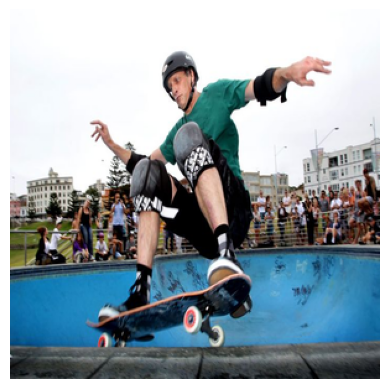

In [ ]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is doing a trick on a skateboard .
a man doing a trick on a skateboard on a ramp .
a skateboarder doing a trick on a ramp .
a man is doing a trick on a skateboard .
a man on a skateboard doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man riding a skateboard on a ramp .


### 5. Demo (2.5 балла)
##### **Найдите как минимум 10 изображений для теста.**

* Серьёзно, это часть задания — подготовьте хотя бы 10 картинок для генерации подписей.

* Сначала проверьте работу модели на простых изображениях, прежде чем переходить к более сложным.

* В вашем наборе должны быть примеры как удачных, так и неудачных подписей — проявите креативность :)

* Используйте фотографии, а не анимацию, 3D или рисунки — иначе придётся переобучать CNN на аниме.

* Обратите внимание на соотношение сторон изображений.

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1bVxF1ipvgouf5PkNkBDe1nXYHdu8E7kH

Retrieving folder contents
Processing file 1hhncrWqFYAHTw8U757tfhGqr5wpmq5TO 1Dog-rough-collie-portrait.jpg
Processing file 1hbpWweAKnTCC04oJvuRT4RX3DcBBW4D4 A_small_cup_of_coffee.jpeg
Processing file 1h8oGSdaTWSjU7yAaz9y7KYvZyhXEbAXD Austria_-_Göttweig_Abbey_-_2015.jpg
Processing file 13a4SLyOA8QOa9yB8aPhK8ZIzj21oWxk1 Chef_at_Jimmy's_World_Grill_&_Bar.jpg
Processing file 18s7xH1S2KbpR27I7wOa-zXzxsSKYXVom Felis_silvestris_silvestris.jpg
Processing file 15BqDf8sIEOa_sGv0EShxLwi8WaAu-XUA Game_between_Lithuania_and_Brazil_men's_national_basketball_teams_at_the_2016_Summer_Olympics_(2).jpg
Processing file 1-2DeUm_SyQViY4S8YMGlT6QgEq8kLAid Gordan_Kozulj_Croatia_backstroke_EC.jpg
Processing file 1U931qaOwUK6hdTVLSp1zKXHgmyOv6fPd La_Boqueria.jpeg
Processing file 1sQL5Yes0i87xRGKY1z6D-syK5h6phIbl LiAZ-5292.65_on_route_M7_(26.06.2019).jpg
Processing file 1a13N7mRsSBHdxBSaWzV1OeLWO8fAX376 Shunsuke1_20080622.jpg
Retrieving folder contents completed
Building directory structure
Building directory 

In [ ]:
import glob, os


def process_images(folder_path="/content/Images"):

    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.webp']
    image_files = []

    for extension in image_extensions:
        image_files.extend(glob.glob(os.path.join(folder_path, extension)))
        image_files.extend(glob.glob(os.path.join(folder_path, extension.upper())))


    for i, image_path in enumerate(image_files):
        print(f"\n{'='*80}")
        print(f"🖼️ ИЗОБРАЖЕНИЕ {i+1}/{len(image_files)}")
        print(f"{'='*80}")


        img = plt.imread(image_path)
        img_processed = imresize(img, (299, 299)).astype('float32') / 255.

        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        print("\n📝 Подписи:")
        for j in range(10):
            caption = generate_caption(img_processed, t=5.)
            clean_caption = ' '.join(caption[1:-1])
            print(f"  {j+1}. {clean_caption}")


🖼️ ИЗОБРАЖЕНИЕ 1/10


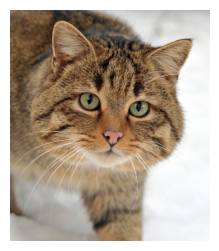


📝 Подписи:
  1. a cat is laying down on a chair .
  2. a cat is sitting on a chair with a cat .
  3. a cat is sitting on a chair next to a window .
  4. a cat is laying down on a chair .
  5. a cat is laying down on a chair .
  6. a cat is laying on a wooden floor .
  7. a cat is laying on a wooden floor .
  8. a cat is laying on a bench next to a window .
  9. a cat is laying down on a chair .
  10. a cat is sitting on a wooden floor .

🖼️ ИЗОБРАЖЕНИЕ 2/10


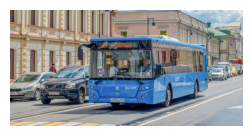


📝 Подписи:
  1. a bus is parked on the side of the road .
  2. a bus is parked on the side of a road .
  3. a bus parked on the side of a road .
  4. a bus parked on the side of a road .
  5. a bus is parked on the side of a road .
  6. a bus parked on the side of a road .
  7. a bus is parked on the side of a road .
  8. a bus with a bus on the side of it
  9. a bus parked on a street next to a building .
  10. a bus is parked on a street next to a building .

🖼️ ИЗОБРАЖЕНИЕ 3/10


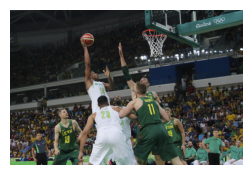


📝 Подписи:
  1. a baseball player is swinging at a ball .
  2. a baseball player is swinging at a pitch .
  3. a baseball player is swinging a bat at a baseball .
  4. a baseball player is swinging at a ball .
  5. a baseball player is swinging at a ball .
  6. a baseball player is swinging a bat at a ball .
  7. a baseball player is holding a bat in a baseball game .
  8. a baseball player is swinging at a ball .
  9. a group of people playing a game of baseball .
  10. a group of people playing a game of baseball .

🖼️ ИЗОБРАЖЕНИЕ 4/10


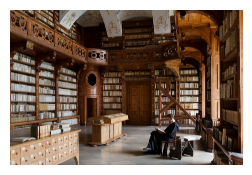


📝 Подписи:
  1. a room with a table and a clock on it .
  2. a kitchen with a large clock and a table
  3. a kitchen with a large clock and a wooden floor .
  4. a kitchen with a large clock on the side of it .
  5. a kitchen with a wooden floor and a table .
  6. a kitchen with a large clock and a refrigerator .
  7. a kitchen with a large clock and a table
  8. a kitchen with a wooden table and a window .
  9. a room with a large clock on the front of it
  10. a kitchen with a large clock and a large window .

🖼️ ИЗОБРАЖЕНИЕ 5/10


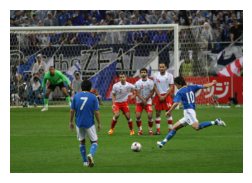


📝 Подписи:
  1. a soccer player is playing soccer on a field .
  2. a soccer player is playing soccer on a field
  3. a group of people playing soccer on a field .
  4. a group of people playing soccer on a field .
  5. a group of people playing a game of soccer .
  6. a soccer player in a soccer ball and a soccer ball .
  7. a group of people playing soccer on a field .
  8. a group of people playing soccer on a field .
  9. a soccer player in a soccer ball and a soccer ball .
  10. a soccer player in a field playing soccer .

🖼️ ИЗОБРАЖЕНИЕ 6/10


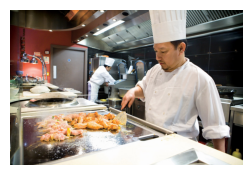


📝 Подписи:
  1. a man in a kitchen preparing food in a kitchen .
  2. a man in a kitchen preparing food on a table .
  3. a man is preparing food in a kitchen .
  4. a man is preparing food in a kitchen .
  5. a man is preparing food in a kitchen .
  6. a man is preparing to a woman in a kitchen .
  7. a man in a kitchen preparing food on a table .
  8. a man is preparing food in a kitchen .
  9. a man in a kitchen preparing food on a stove
  10. a man in a kitchen preparing food on a table

🖼️ ИЗОБРАЖЕНИЕ 7/10


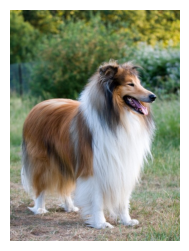


📝 Подписи:
  1. a dog is standing on a green field .
  2. a white and black dog is sitting on a bench .
  3. a white and black dog is standing on a skateboard .
  4. a dog is standing next to a dog .
  5. a dog is sitting on a bench next to a black and white dog .
  6. a dog with a black and white dog on a leash .
  7. a white and black dog is sitting on a bench .
  8. a dog is on a wooden floor .
  9. a dog and a dog are playing with a frisbee .
  10. a dog with a red and white dog on a leash .

🖼️ ИЗОБРАЖЕНИЕ 8/10


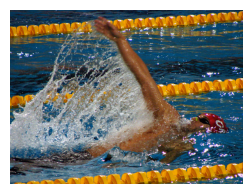


📝 Подписи:
  1. a man is holding a surfboard in the water .
  2. a man riding a wave on top of a surfboard .
  3. a man riding a wave on top of a surfboard .
  4. a man is riding a wave on a surfboard .
  5. a man is riding a wave on a surfboard .
  6. a man is riding a wave on a surfboard .
  7. a man is riding a wave on a surfboard .
  8. a man on a surfboard riding a wave .
  9. a man is riding a wave on a surfboard .
  10. a man is riding a wave in the ocean .

🖼️ ИЗОБРАЖЕНИЕ 9/10


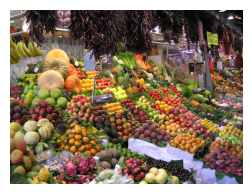


📝 Подписи:
  1. a bunch of fruit are in a market .
  2. a group of people stand in a market .
  3. a market with fruit and vegetables on it
  4. a market with fruit and bananas on it
  5. a bunch of fruit are sitting on a table .
  6. a market with fruit and vegetables on it
  7. a bunch of fruit stand on a table
  8. a bunch of fruit are sitting on a table .
  9. a market with fruit and oranges in a market .
  10. a bunch of fruit on a tree in a market

🖼️ ИЗОБРАЖЕНИЕ 10/10


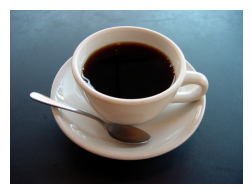


📝 Подписи:
  1. a cup of coffee and a cup of coffee .
  2. a white and black cat sitting on a table .
  3. a cup of coffee and a cup of coffee .
  4. a cup of coffee and a cup of coffee .
  5. a cup of coffee and a cup of coffee .
  6. a white plate with a cup of coffee and a cup of coffee .
  7. a cup of coffee and a cup of coffee .
  8. a close up of a cup of coffee and a cup of coffee
  9. a cup of coffee and a cup of coffee
  10. a small cup of coffee and a cup of coffee .


In [ ]:
process_images()


![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)

> Примечание: Это задание адаптировано по материалам курса "Deep Learning" (Skoltech).
